<a href="https://colab.research.google.com/github/kentokura/python_medical_images/blob/master/chapter3/chap3_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from IPython.display import Image, display_png

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 3.9 画像の演算

- 画像同士を引き算する

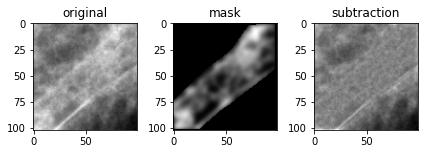

In [15]:
img = cv2.imread('/content/drive/My Drive/DATASET/dataset/ChestCrop.tif',
                  cv2.IMREAD_UNCHANGED)
mask = cv2.imread('/content/drive/My Drive/DATASET/dataset/ChestCrop-RibMaskWithGaussian.tif', 
                  cv2.IMREAD_UNCHANGED)
sub = img - mask
plt.subplot(1,3,1), plt.imshow(img, cmap = 'gray'), plt.title("original")
plt.subplot(1,3,2), plt.imshow(mask, cmap = 'gray'), plt.title("mask")
plt.subplot(1,3,3), plt.imshow(sub, cmap = 'gray'), plt.title("subtraction")
plt.tight_layout()
plt.show()